# Fine-Grained Visual Classification of Aircraft (FGVC-Aircraft) Using CNNs and PyTorch

# Project Description:
The goal of this project is to use deep learning to classify aircraft photos into fine-grained categories. The FGVC-Aircraft Benchmark dataset, which comprises 102 airplane variants, will be used to train a convolutional neural network (CNN). This task offers a realistic and demanding environment for image classification because of the high visual similarity between classes (e.g., different Boeing 737 variants).
Since the dataset contains 10,200 images of aircraft, with 100 images for each of 102 different aircraft model variants, we will use a subset of 10 randomly selected classes.
The objective is to use PyTorch to create a deep learning model that can correctly classify aircraft into a number of predetermined categories. In order to understand the model's behaviour, we will assess it using common classification metrics and examine misclassifications.

## 1. Dataset Download and Preparation

let's download and prepare the FGVC-Aircraft dataset. We'll select a subset of classes and create train/validation/test splits.

In [ ]:
import os
import urllib.request
import tarfile

# Step 1: Download the dataset (variant-level images)
url = "https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz"
output_path = "fgvc-aircraft-2013b.tar.gz"

if not os.path.exists(output_path):
    print("Downloading FGVC-Aircraft dataset...")
    urllib.request.urlretrieve(url, output_path)
    print("Download complete.")

# Step 2: Extract the tar.gz file
extract_dir = "FGVC-Aircraft"
if not os.path.exists(extract_dir):
    print("Extracting...")
    with tarfile.open(output_path, "r:gz") as tar:
        tar.extractall()
    os.rename("fgvc-aircraft-2013b", extract_dir)
    print("Extraction complete.")

# Step 3: Check the structure
print("\nTop-level contents:")
print(os.listdir(extract_dir))

images_dir = os.path.join(extract_dir, "data", "images")
print("\nNumber of image files:", len(os.listdir(images_dir)))

annotations_dir = os.path.join(extract_dir, "data", "images_variant_train.txt")
print("\nSample annotation (images_variant_train.txt):")
with open(annotations_dir, "r") as f:
    for i in range(5):
        print(f.readline().strip())


Download complete.
Extracting...
Extraction complete.

Top-level contents:
['data', 'README.html', 'evaluation.m', 'vl_roc.m', 'vl_tpfp.m', 'example_evaluation.m', 'vl_pr.m', 'README.md', 'vl_argparse.m']

Number of image files: 10000

Sample annotation (images_variant_train.txt):
1025794 707-320
1340192 707-320
0056978 707-320
0698580 707-320
0450014 707-320


Choose 10 random classes

In [ ]:
import os
import shutil
import random
from collections import defaultdict

# Reproducibility
random.seed(42)

# Original dataset paths
original_images_dir = "FGVC-Aircraft/data/images"
split_dir = "FGVC-Aircraft-subset"
os.makedirs(split_dir, exist_ok=True)

# Annotations for each split
splits = {
    "train": "FGVC-Aircraft/data/images_variant_train.txt",
    "val": "FGVC-Aircraft/data/images_variant_val.txt",
    "test": "FGVC-Aircraft/data/images_variant_test.txt"
}

# Step 1: Parse annotations into {split: [(filename, class)]}
annotations = defaultdict(list)
all_classes = set()

for split_name, filepath in splits.items():
    with open(filepath, 'r') as f:
        for line in f:
            img_name, label = line.strip().split(' ', 1)
            label = label.replace(" ", "_")  # make folder-safe
            all_classes.add(label)
            annotations[split_name].append((img_name + ".jpg", label))

# Step 2: Choose 10 random classes
selected_classes = sorted(random.sample(list(all_classes), 10)) # Fix: Convert set to list
print("Selected 10 classes:\n", selected_classes)

# Step 3: Filter annotations to only include selected classes
filtered_annotations = defaultdict(list)
for split_name in annotations:
    for filename, class_name in annotations[split_name]:
        if class_name in selected_classes:
            filtered_annotations[split_name].append((filename, class_name))

# Step 4: Organize into ImageFolder-style directory
for split_name, items in filtered_annotations.items():
    for filename, class_name in items:
        src_path = os.path.join(original_images_dir, filename)
        dst_dir = os.path.join(split_dir, split_name, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, filename)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

# Done
print("\n📂 Dataset organized in:", split_dir)
for split in ["train", "val", "test"]:
    count = sum(len(files) for _, _, files in os.walk(os.path.join(split_dir, split)))
    print(f" - {split}: {count} images")

Selected 10 classes:
 ['707-320', '737-400', '767-300', 'DC-9-30', 'DH-82', 'Falcon_2000', 'Il-76', 'MD-11', 'Metroliner', 'PA-28']

📂 Dataset organized in: FGVC-Aircraft-subset
 - train: 332 images
 - val: 333 images
 - test: 335 images


##2. Data Preprocessing:

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define image size and batch size
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Normalization values (ImageNet mean/std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation and test preprocessing (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets
data_root = "FGVC-Aircraft-subset"

train_dataset = datasets.ImageFolder(root=f"{data_root}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_root}/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_root}/test", transform=val_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Class names
class_names = train_dataset.classes
print(f"Loaded {len(class_names)} classes: {class_names}")


Loaded 10 classes: ['707-320', '737-400', '767-300', 'DC-9-30', 'DH-82', 'Falcon_2000', 'Il-76', 'MD-11', 'Metroliner', 'PA-28']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


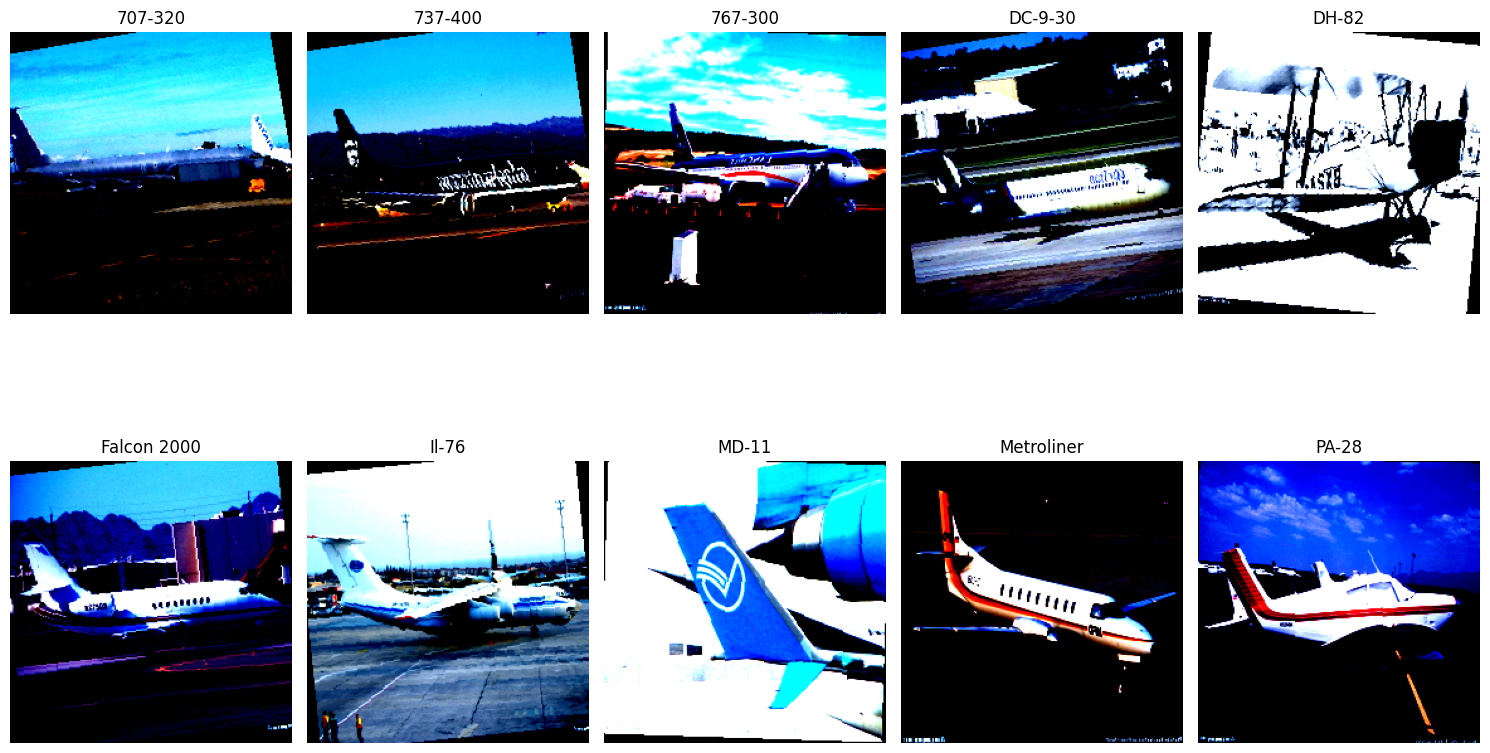

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store the first image found for each class
class_images = {}

# Iterate through the dataset to find one image per class
# Assuming train_dataset is already loaded and contains class information
for img, label_idx in train_dataset:
    label = class_names[label_idx]

    # If we haven't found an image for this class yet, store it
    if label not in class_images:
        class_images[label] = img

    # Stop once we have an image for every class
    if len(class_images) == len(class_names):
        break

# Plot an image for each class
plt.figure(figsize=(15, 10))
for i, (label, img) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1) # Adjust subplot grid as needed
    # Convert tensor to numpy array and transpose for matplotlib (if not already)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(label.replace("_", " ")) # Display class name nicely
    plt.axis('off')

plt.tight_layout()
plt.show()

#3. Model Selection
##3.1 Softmax Classifier
Lets start with a softmax classifier

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# build custom softmax module
class Softmax(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Softmax, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        pred = self.linear(x)
        return pred

# call Softmax Classifier
# FGVC-Aircraft subset images are 224x224 with 3 channels
model_softmax = Softmax(IMAGE_SIZE * IMAGE_SIZE * 3, len(class_names))

# define loss, optimizier, and dataloader for train and validation sets
optimizer = torch.optim.SGD(model_softmax.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

# Use the existing train_loader and val_loader defined earlier
# train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True) # Using existing train_loader

epochs = 100
Loss = []
train_acc = []
val_acc = []

# Early stopping parameters
best_val_acc = 0
patience = 10
epochs_no_improve = 0

print("Starting training with early stopping...")
for epoch in range(epochs):
    model_softmax.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model_softmax(images.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    Loss.append(epoch_loss)
    train_acc.append(epoch_train_acc)

    # Validation
    model_softmax.eval() # Set model to evaluation mode
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images_val, labels_val in val_loader:
            outputs_val = model_softmax(images_val.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()
    epoch_val_acc = 100 * correct_val / total_val
    val_acc.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Acc: {epoch_val_acc:.2f}%")

    # Early stopping check
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        epochs_no_improve = 0
        # Optionally save the best model state
        # torch.save(model_softmax.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break # Stop training loop

print("\nTraining finished.")

Starting training with early stopping...
Epoch [1/100], Loss: 81.6485, Train Acc: 15.96%, Val Acc: 23.42%
Epoch [2/100], Loss: 82.6604, Train Acc: 16.87%, Val Acc: 18.92%
Epoch [3/100], Loss: 100.1191, Train Acc: 20.48%, Val Acc: 27.93%
Epoch [4/100], Loss: 69.4591, Train Acc: 29.22%, Val Acc: 19.22%
Epoch [5/100], Loss: 76.2789, Train Acc: 28.61%, Val Acc: 22.52%
Epoch [6/100], Loss: 62.2670, Train Acc: 34.04%, Val Acc: 30.93%
Epoch [7/100], Loss: 59.0638, Train Acc: 33.73%, Val Acc: 23.12%
Epoch [8/100], Loss: 46.1831, Train Acc: 39.76%, Val Acc: 29.13%
Epoch [9/100], Loss: 48.9626, Train Acc: 37.95%, Val Acc: 27.03%
Epoch [10/100], Loss: 51.4936, Train Acc: 43.37%, Val Acc: 27.03%
Epoch [11/100], Loss: 48.1893, Train Acc: 40.96%, Val Acc: 26.13%
Epoch [12/100], Loss: 43.1077, Train Acc: 41.87%, Val Acc: 20.12%
Epoch [13/100], Loss: 36.3204, Train Acc: 50.30%, Val Acc: 27.33%
Epoch [14/100], Loss: 37.5914, Train Acc: 48.19%, Val Acc: 29.43%
Epoch [15/100], Loss: 37.7502, Train Acc: 4

### 3.1.1 Evaluating the soft max classifier

In [6]:
# Evaluate the model on the test set
model_softmax.eval() # Set the model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad(): # Disable gradient calculation for evaluation
    for images_test, labels_test in test_loader:
        # Flatten images for the softmax model
        outputs_test = model_softmax(images_test.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
        # Get the predicted class with the highest score
        _, predicted_test = torch.max(outputs_test.data, 1)
        # Update total and correct counts
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

# Calculate and print the test accuracy
test_accuracy = 100 * correct_test / total_test
print(f"Accuracy of the model on the {total_test} test images: {test_accuracy:.2f}%")

Accuracy of the model on the 335 test images: 31.64%


In [7]:
from sklearn.metrics import classification_report
import torch

model_softmax.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        # Flatten images for the softmax model, using the correct image size
        outputs = model_softmax(images.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Print report
print(classification_report(y_true, y_pred, target_names=class_names))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

     707-320       0.11      0.12      0.12        33
     737-400       0.16      0.58      0.25        33
     767-300       0.17      0.09      0.12        34
     DC-9-30       0.18      0.24      0.21        34
       DH-82       0.62      0.24      0.35        33
 Falcon_2000       0.53      0.26      0.35        34
       Il-76       0.70      0.62      0.66        34
       MD-11       0.57      0.24      0.34        33
  Metroliner       0.36      0.15      0.21        34
       PA-28       0.68      0.64      0.66        33

    accuracy                           0.32       335
   macro avg       0.41      0.32      0.33       335
weighted avg       0.41      0.32      0.32       335




### 3.1.3 Tune the hyperparameters of the Softmax classifier model for the CIFAR-10 dataset to optimize its performance.

In [8]:
# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128],
    'epochs': [25, 50, 100], # Maximum epochs, early stopping is used
    'optimizer': ['SGD', 'Adam'] # Include different optimizers
}

print("Hyperparameter search space defined:")
for param, values in param_grid.items():
    print(f"- {param}: {values}")

Hyperparameter search space defined:
- learning_rate: [0.01, 0.001, 0.0001]
- batch_size: [32, 64, 128]
- epochs: [25, 50, 100]
- optimizer: ['SGD', 'Adam']



### Defining the `train_and_evaluate` function to train and evaluate the model with given hyperparameters.



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy # Import copy for deepcopy

def train_and_evaluate(hyperparameters, train_loader_base, val_loader_base, image_size, num_classes):
    """
    Trains and evaluates a Softmax classifier model with the given hyperparameters.

    Args:
        hyperparameters (dict): A dictionary containing the hyperparameters:
                                'learning_rate', 'batch_size', 'epochs', 'optimizer'.
        train_loader_base (DataLoader): The base DataLoader for the training dataset.
        val_loader_base (DataLoader): The base DataLoader for the validation dataset.
        image_size (int): The size of the images (e.g., 224).
        num_classes (int): The number of output classes.

    Returns:
        float: The best validation accuracy achieved during training.
    """
    # Reset model and optimizer states for each run
    model = Softmax(image_size * image_size * 3, num_classes)

    # Select optimizer
    if hyperparameters['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=hyperparameters['learning_rate'])
    elif hyperparameters['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    else:
        raise ValueError("Unsupported optimizer")

    criterion = nn.CrossEntropyLoss()

    # Recreate DataLoaders with the specified batch size
    train_loader = DataLoader(train_loader_base.dataset, batch_size=hyperparameters['batch_size'], shuffle=True, num_workers=train_loader_base.num_workers)
    val_loader = DataLoader(val_loader_base.dataset, batch_size=hyperparameters['batch_size'], shuffle=False, num_workers=val_loader_base.num_workers)


    epochs = hyperparameters['epochs']
    best_val_acc = 0.0
    epochs_no_improve = 0
    patience = 10 # Using a fixed patience for early stopping

    print(f"Training with hyperparameters: {hyperparameters}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.view(-1, image_size * image_size * 3))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                outputs_val = model(images_val.view(-1, image_size * image_size * 3))
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        epoch_val_acc = 100 * correct_val / total_val

        # Print progress (optional, but helpful)
        # print(f"  Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {100*correct_train/total_train:.2f}%, Val Acc: {epoch_val_acc:.2f}%")


        # Early stopping check
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"  Early stopping triggered at epoch {epoch+1}.")
                break

    print(f"  Finished training. Best Val Acc: {best_val_acc:.2f}%")
    return best_val_acc


#### Iterate through all hyperparameter combinations defined in `param_grid`, call the `train_and_evaluate` function for each combination, and store the results.


In [ ]:
import itertools

# Create an empty list to store the outcomes
results = []

# Get the keys and values from the param_grid
keys = param_grid.keys()
values = param_grid.values()

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(*values))

print(f"Generated {len(hyperparameter_combinations)} hyperparameter combinations.")

# Loop through each combination
for combination in hyperparameter_combinations:
    # Create a dictionary for the current combination
    current_hyperparameters = dict(zip(keys, combination))

    # Call the train_and_evaluate function
    # Ensure train_loader and val_loader from previous cells are available
    # Ensure IMAGE_SIZE and class_names from previous cells are available
    print("-" * 30)
    best_val_accuracy = train_and_evaluate(
        current_hyperparameters,
        train_loader, # Using the train_loader defined previously
        val_loader,   # Using the val_loader defined previously
        IMAGE_SIZE,
        len(class_names) # Using the class_names defined previously
    )

    # Store the results
    results.append({
        "hyperparameters": current_hyperparameters,
        "best_val_accuracy": best_val_accuracy
    })

# Print the results
print("\n--- Hyperparameter Tuning Results ---")
for result in results:
    print(result)

Generated 54 hyperparameter combinations.
------------------------------
Training with hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 25, 'optimizer': 'SGD'}
  Finished training. Best Val Acc: 28.06%
------------------------------
Training with hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 25, 'optimizer': 'Adam'}
  Finished training. Best Val Acc: 31.94%
------------------------------
Training with hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}
  Early stopping triggered at epoch 23.
  Finished training. Best Val Acc: 27.76%
------------------------------
Training with hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}
  Early stopping triggered at epoch 26.
  Finished training. Best Val Acc: 33.73%
------------------------------
Training with hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}
  Early stopping 

#### Identify the best hyperparameters



In [ ]:
# Identify the best hyperparameters
best_accuracy = -1
best_hyperparameters = None

for result in results:
    if result["best_val_accuracy"] > best_accuracy:
        best_accuracy = result["best_val_accuracy"]
        best_hyperparameters = result["hyperparameters"]

# Print the best hyperparameters and their corresponding best validation accuracy
print("\n--- Best Hyperparameters Found ---")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print("Best Hyperparameters:", best_hyperparameters)


--- Best Hyperparameters Found ---
Best Validation Accuracy: 39.10%
Best Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 25, 'optimizer': 'Adam'}


### 3.1.2 Train the final Softmax classifier model


In [11]:
import torch
from torch.utils.data import ConcatDataset

# 1. Combine training and validation datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])

# 2. Create a new DataLoader for the combined dataset
# best_batch_size = best_hyperparameters['batch_size']
best_batch_size = 128
final_train_loader = DataLoader(combined_dataset, batch_size=best_batch_size, shuffle=True, num_workers=4)

# 3. Instantiate a new Softmax model
final_model = Softmax(IMAGE_SIZE * IMAGE_SIZE * 3, len(class_names))

# 4. Choose and initialize the optimizer
#best_lr = best_hyperparameters['learning_rate']
best_lr = 0.0001

#if best_hyperparameters['optimizer'] == 'Adam':
   # optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)
#else:
    #optimizer = torch.optim.SGD(final_model.parameters(), lr=best_lr)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)

# 5. Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# 6. Train the model
#epochs = best_hyperparameters['epochs']
epochs = 25
patience = 10
epochs_no_improve = 0
best_loss = float('inf')

print("--- Starting Final Model Training on Combined Data ---")
#print(f"Using hyperparameters: {best_hyperparameters}")

for epoch in range(epochs):
    final_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in final_train_loader:
        optimizer.zero_grad()
        outputs = final_model(images.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(final_train_loader)
    epoch_train_acc = 100 * correct_train / total_train

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%")

    # Early stopping based on loss improvement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        # Save the best model state during training
        torch.save(final_model.state_dict(), 'final_best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

# 7. Save the final trained model's state dictionary
torch.save(final_model.state_dict(), 'final_softmax_model.pth')
print("\n Final model training complete. Model saved to 'final_softmax_model.pth'")
print("Best model during training saved to 'final_best_model.pth'")


--- Starting Final Model Training on Combined Data ---
Epoch [1/25], Loss: 4.2660, Accuracy: 21.05%
Epoch [2/25], Loss: 3.8224, Accuracy: 34.14%
Epoch [3/25], Loss: 2.8532, Accuracy: 38.95%
Epoch [4/25], Loss: 2.0931, Accuracy: 50.83%
Epoch [5/25], Loss: 2.1349, Accuracy: 53.23%
Epoch [6/25], Loss: 1.5835, Accuracy: 59.25%
Epoch [7/25], Loss: 1.4349, Accuracy: 62.11%
Epoch [8/25], Loss: 1.2597, Accuracy: 64.66%
Epoch [9/25], Loss: 1.1207, Accuracy: 68.12%
Epoch [10/25], Loss: 0.9015, Accuracy: 72.93%
Epoch [11/25], Loss: 1.0511, Accuracy: 72.78%
Epoch [12/25], Loss: 1.2208, Accuracy: 68.27%
Epoch [13/25], Loss: 1.1041, Accuracy: 67.67%
Epoch [14/25], Loss: 1.1047, Accuracy: 71.58%
Epoch [15/25], Loss: 1.0919, Accuracy: 68.87%
Epoch [16/25], Loss: 0.9944, Accuracy: 71.43%
Epoch [17/25], Loss: 1.0466, Accuracy: 71.43%
Epoch [18/25], Loss: 0.9647, Accuracy: 73.68%
Epoch [19/25], Loss: 0.9295, Accuracy: 76.99%
Epoch [20/25], Loss: 0.8865, Accuracy: 76.84%
Epoch [21/25], Loss: 0.7579, Accur

#### Evaluate on the test set

In [12]:
import torch

# Define the path to the saved best model state dictionary
model_path = 'final_best_model.pth'

# Instantiate a new Softmax model with the same structure
final_model_eval = Softmax(IMAGE_SIZE * IMAGE_SIZE * 3, len(class_names))

# Load the saved state dictionary
final_model_eval.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
final_model_eval.eval()

# Initialize variables to track correct predictions and total samples
correct_test = 0
total_test = 0

# Iterate through the test_loader
with torch.no_grad(): # Disable gradient calculation for evaluation
    for images_test, labels_test in test_loader:
        # Flatten images for the softmax model
        outputs_test = final_model_eval(images_test.view(-1, IMAGE_SIZE * IMAGE_SIZE * 3))
        # Get the predicted class with the highest score
        _, predicted_test = torch.max(outputs_test.data, 1)
        # Update total and correct counts
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

# Calculate and print the test accuracy
test_accuracy = 100 * correct_test / total_test
print(f"Accuracy of the final trained model on the {total_test} test images: {test_accuracy:.2f}%")


Accuracy of the final trained model on the 335 test images: 45.67%


### Summary:

* The relatively low accuracy on the test set (45.67%) indicates that a simple Softmax classifier is not sufficient for this image classification task, likely due to its inability to capture complex spatial features.
* The early stopping mechanism helped prevent overfitting to the training data.
* **Next Steps:** To significantly improve performance, we will transition to a more powerful model architecture, ResNEt18.

### 3.2 CNN Model (pre-trained ResNet18)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


Starting training with early stopping...


Epoch 1/100 - Training:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch 1: Train Loss: 2.4338, Train Accuracy: 9.64%, Val Loss: 2.2894, Val Accuracy: 14.71%


Epoch 2/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]


Epoch 2: Train Loss: 2.2668, Train Accuracy: 18.37%, Val Loss: 2.1668, Val Accuracy: 20.42%


Epoch 3/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch 3: Train Loss: 2.0915, Train Accuracy: 28.31%, Val Loss: 2.0531, Val Accuracy: 25.53%


Epoch 4/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch 4: Train Loss: 1.9632, Train Accuracy: 34.34%, Val Loss: 1.9456, Val Accuracy: 33.93%


Epoch 5/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Epoch 5: Train Loss: 1.8687, Train Accuracy: 41.57%, Val Loss: 1.8223, Val Accuracy: 42.64%


Epoch 6/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch 6: Train Loss: 1.7305, Train Accuracy: 47.89%, Val Loss: 1.7464, Val Accuracy: 45.35%


Epoch 7/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch 7: Train Loss: 1.6636, Train Accuracy: 56.02%, Val Loss: 1.6725, Val Accuracy: 47.15%


Epoch 8/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 8: Train Loss: 1.5928, Train Accuracy: 56.63%, Val Loss: 1.6220, Val Accuracy: 50.15%


Epoch 9/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 9: Train Loss: 1.5088, Train Accuracy: 54.82%, Val Loss: 1.5685, Val Accuracy: 49.85%


Epoch 10/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


Epoch 10: Train Loss: 1.4519, Train Accuracy: 63.86%, Val Loss: 1.5126, Val Accuracy: 55.26%


Epoch 11/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


Epoch 11: Train Loss: 1.3960, Train Accuracy: 64.16%, Val Loss: 1.5179, Val Accuracy: 52.25%


Epoch 12/100 - Validation: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Epoch 12: Train Loss: 1.3691, Train Accuracy: 65.06%, Val Loss: 1.4360, Val Accuracy: 55.86%


Epoch 13/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch 13: Train Loss: 1.2893, Train Accuracy: 68.37%, Val Loss: 1.4248, Val Accuracy: 57.06%


Epoch 14/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch 14: Train Loss: 1.2787, Train Accuracy: 70.18%, Val Loss: 1.3894, Val Accuracy: 56.76%


Epoch 15/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch 15: Train Loss: 1.1820, Train Accuracy: 75.90%, Val Loss: 1.3786, Val Accuracy: 56.16%


Epoch 16/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 16: Train Loss: 1.1198, Train Accuracy: 77.71%, Val Loss: 1.3164, Val Accuracy: 61.86%


Epoch 17/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch 17: Train Loss: 1.1259, Train Accuracy: 72.89%, Val Loss: 1.3152, Val Accuracy: 60.36%


Epoch 18/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


Epoch 18: Train Loss: 1.0833, Train Accuracy: 73.80%, Val Loss: 1.2931, Val Accuracy: 59.76%


Epoch 19/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


Epoch 19: Train Loss: 1.0637, Train Accuracy: 76.51%, Val Loss: 1.2670, Val Accuracy: 62.46%


Epoch 20/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 20: Train Loss: 1.0895, Train Accuracy: 74.70%, Val Loss: 1.2574, Val Accuracy: 60.96%


Epoch 21/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch 21: Train Loss: 1.0387, Train Accuracy: 73.49%, Val Loss: 1.2494, Val Accuracy: 61.56%


Epoch 22/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 22: Train Loss: 1.0318, Train Accuracy: 76.20%, Val Loss: 1.2210, Val Accuracy: 64.56%


Epoch 23/100 - Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 23: Train Loss: 0.9724, Train Accuracy: 78.31%, Val Loss: 1.2257, Val Accuracy: 61.86%


Epoch 24/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


Epoch 24: Train Loss: 0.9674, Train Accuracy: 79.82%, Val Loss: 1.2024, Val Accuracy: 62.46%


Epoch 25/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 25: Train Loss: 0.9393, Train Accuracy: 79.82%, Val Loss: 1.2227, Val Accuracy: 61.56%


Epoch 26/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 26: Train Loss: 0.8857, Train Accuracy: 79.52%, Val Loss: 1.1907, Val Accuracy: 62.16%


Epoch 27/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


Epoch 27: Train Loss: 0.9024, Train Accuracy: 79.52%, Val Loss: 1.1629, Val Accuracy: 64.56%


Epoch 28/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


Epoch 28: Train Loss: 0.9572, Train Accuracy: 75.60%, Val Loss: 1.1588, Val Accuracy: 65.17%


Epoch 29/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch 29: Train Loss: 0.9122, Train Accuracy: 75.30%, Val Loss: 1.1817, Val Accuracy: 62.46%


Epoch 30/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Epoch 30: Train Loss: 0.8835, Train Accuracy: 78.61%, Val Loss: 1.1340, Val Accuracy: 65.47%


Epoch 31/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch 31: Train Loss: 0.8468, Train Accuracy: 81.02%, Val Loss: 1.1509, Val Accuracy: 64.26%


Epoch 32/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 32: Train Loss: 0.8320, Train Accuracy: 80.72%, Val Loss: 1.1335, Val Accuracy: 63.06%


Epoch 33/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 33: Train Loss: 0.8330, Train Accuracy: 81.02%, Val Loss: 1.1011, Val Accuracy: 65.17%


Epoch 34/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


Epoch 34: Train Loss: 0.8086, Train Accuracy: 81.33%, Val Loss: 1.1268, Val Accuracy: 63.66%


Epoch 35/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


Epoch 35: Train Loss: 0.8080, Train Accuracy: 83.43%, Val Loss: 1.1135, Val Accuracy: 63.96%


Epoch 36/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 36: Train Loss: 0.7797, Train Accuracy: 81.63%, Val Loss: 1.1192, Val Accuracy: 64.26%


Epoch 37/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch 37: Train Loss: 0.7612, Train Accuracy: 83.43%, Val Loss: 1.0871, Val Accuracy: 64.26%


Epoch 38/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]


Epoch 38: Train Loss: 0.7247, Train Accuracy: 82.83%, Val Loss: 1.0909, Val Accuracy: 65.47%


Epoch 39/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.00it/s]


Epoch 39: Train Loss: 0.7498, Train Accuracy: 84.34%, Val Loss: 1.0807, Val Accuracy: 64.86%


Epoch 40/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 40: Train Loss: 0.7269, Train Accuracy: 85.84%, Val Loss: 1.0850, Val Accuracy: 64.26%


Epoch 41/100 - Validation: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Epoch 41: Train Loss: 0.7369, Train Accuracy: 84.04%, Val Loss: 1.0758, Val Accuracy: 65.17%


Epoch 42/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Epoch 42: Train Loss: 0.7456, Train Accuracy: 83.73%, Val Loss: 1.0625, Val Accuracy: 65.77%


Epoch 43/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch 43: Train Loss: 0.7060, Train Accuracy: 84.34%, Val Loss: 1.0832, Val Accuracy: 64.56%


Epoch 44/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


Epoch 44: Train Loss: 0.7304, Train Accuracy: 86.14%, Val Loss: 1.0470, Val Accuracy: 66.37%


Epoch 45/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


Epoch 45: Train Loss: 0.6744, Train Accuracy: 88.55%, Val Loss: 1.0385, Val Accuracy: 65.47%


Epoch 46/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 46: Train Loss: 0.6757, Train Accuracy: 84.94%, Val Loss: 1.0661, Val Accuracy: 64.86%


Epoch 47/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


Epoch 47: Train Loss: 0.7099, Train Accuracy: 87.35%, Val Loss: 1.0548, Val Accuracy: 65.77%


Epoch 48/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


Epoch 48: Train Loss: 0.6560, Train Accuracy: 87.65%, Val Loss: 1.0251, Val Accuracy: 67.27%


Epoch 49/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 49: Train Loss: 0.6705, Train Accuracy: 85.84%, Val Loss: 1.0367, Val Accuracy: 65.17%


Epoch 50/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 50: Train Loss: 0.6687, Train Accuracy: 84.64%, Val Loss: 1.0134, Val Accuracy: 66.67%


Epoch 51/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Epoch 51: Train Loss: 0.6090, Train Accuracy: 86.75%, Val Loss: 1.0511, Val Accuracy: 65.47%


Epoch 52/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch 52: Train Loss: 0.6926, Train Accuracy: 83.13%, Val Loss: 1.0311, Val Accuracy: 66.97%


Epoch 53/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Epoch 53: Train Loss: 0.6166, Train Accuracy: 88.86%, Val Loss: 1.0176, Val Accuracy: 66.37%


Epoch 54/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Epoch 54: Train Loss: 0.6549, Train Accuracy: 86.45%, Val Loss: 1.0071, Val Accuracy: 65.77%


Epoch 55/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


Epoch 55: Train Loss: 0.6579, Train Accuracy: 87.65%, Val Loss: 1.0410, Val Accuracy: 66.67%


Epoch 56/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 56: Train Loss: 0.6041, Train Accuracy: 87.95%, Val Loss: 1.0348, Val Accuracy: 63.96%


Epoch 57/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch 57: Train Loss: 0.6108, Train Accuracy: 88.86%, Val Loss: 1.0127, Val Accuracy: 66.07%


Epoch 58/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 58: Train Loss: 0.6060, Train Accuracy: 89.16%, Val Loss: 1.0034, Val Accuracy: 67.27%


Epoch 59/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch 59: Train Loss: 0.6279, Train Accuracy: 86.45%, Val Loss: 1.0099, Val Accuracy: 66.37%


Epoch 60/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]


Epoch 60: Train Loss: 0.6052, Train Accuracy: 88.55%, Val Loss: 1.0072, Val Accuracy: 67.27%


Epoch 61/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 61: Train Loss: 0.5787, Train Accuracy: 88.55%, Val Loss: 0.9983, Val Accuracy: 67.57%


Epoch 62/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch 62: Train Loss: 0.5930, Train Accuracy: 91.27%, Val Loss: 0.9996, Val Accuracy: 66.37%


Epoch 63/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


Epoch 63: Train Loss: 0.5728, Train Accuracy: 90.66%, Val Loss: 0.9855, Val Accuracy: 68.17%


Epoch 64/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Epoch 64: Train Loss: 0.5578, Train Accuracy: 89.46%, Val Loss: 0.9964, Val Accuracy: 67.57%


Epoch 65/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 65: Train Loss: 0.5697, Train Accuracy: 87.65%, Val Loss: 1.0070, Val Accuracy: 66.37%


Epoch 66/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch 66: Train Loss: 0.5759, Train Accuracy: 87.35%, Val Loss: 0.9910, Val Accuracy: 67.87%


Epoch 67/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch 67: Train Loss: 0.5895, Train Accuracy: 86.14%, Val Loss: 0.9867, Val Accuracy: 68.77%


Epoch 68/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]


Epoch 68: Train Loss: 0.5558, Train Accuracy: 88.25%, Val Loss: 0.9835, Val Accuracy: 67.57%


Epoch 69/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch 69: Train Loss: 0.5530, Train Accuracy: 86.75%, Val Loss: 0.9913, Val Accuracy: 67.57%


Epoch 70/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch 70: Train Loss: 0.5490, Train Accuracy: 89.76%, Val Loss: 0.9924, Val Accuracy: 67.57%


Epoch 71/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 71: Train Loss: 0.5285, Train Accuracy: 91.27%, Val Loss: 0.9883, Val Accuracy: 66.67%


Epoch 72/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 72: Train Loss: 0.5717, Train Accuracy: 88.25%, Val Loss: 0.9907, Val Accuracy: 67.57%


Epoch 73/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]


Epoch 73: Train Loss: 0.5343, Train Accuracy: 89.16%, Val Loss: 0.9922, Val Accuracy: 67.27%


Epoch 74/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch 74: Train Loss: 0.5171, Train Accuracy: 89.16%, Val Loss: 0.9849, Val Accuracy: 67.27%


Epoch 75/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]


Epoch 75: Train Loss: 0.5507, Train Accuracy: 88.55%, Val Loss: 0.9819, Val Accuracy: 66.67%


Epoch 76/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 76: Train Loss: 0.5391, Train Accuracy: 87.35%, Val Loss: 0.9765, Val Accuracy: 67.27%


Epoch 77/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch 77: Train Loss: 0.5275, Train Accuracy: 88.55%, Val Loss: 1.0326, Val Accuracy: 66.37%


Epoch 78/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Epoch 78: Train Loss: 0.5301, Train Accuracy: 88.25%, Val Loss: 0.9866, Val Accuracy: 67.27%


Epoch 79/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 79: Train Loss: 0.5123, Train Accuracy: 89.76%, Val Loss: 0.9825, Val Accuracy: 65.77%


Epoch 80/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch 80: Train Loss: 0.5387, Train Accuracy: 88.55%, Val Loss: 1.0155, Val Accuracy: 65.77%


Epoch 81/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Epoch 81: Train Loss: 0.4626, Train Accuracy: 93.07%, Val Loss: 0.9926, Val Accuracy: 66.67%


Epoch 82/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch 82: Train Loss: 0.4773, Train Accuracy: 92.17%, Val Loss: 0.9786, Val Accuracy: 66.37%


Epoch 83/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch 83: Train Loss: 0.4793, Train Accuracy: 89.46%, Val Loss: 0.9603, Val Accuracy: 68.77%


Epoch 84/100 - Validation: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


Epoch 84: Train Loss: 0.4966, Train Accuracy: 91.57%, Val Loss: 0.9750, Val Accuracy: 66.97%


Epoch 85/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch 85: Train Loss: 0.4620, Train Accuracy: 92.47%, Val Loss: 0.9826, Val Accuracy: 68.17%


Epoch 86/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 86: Train Loss: 0.5131, Train Accuracy: 90.06%, Val Loss: 0.9805, Val Accuracy: 68.17%


Epoch 87/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


Epoch 87: Train Loss: 0.4970, Train Accuracy: 89.46%, Val Loss: 0.9697, Val Accuracy: 67.87%


Epoch 88/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch 88: Train Loss: 0.4874, Train Accuracy: 88.86%, Val Loss: 0.9795, Val Accuracy: 67.27%


Epoch 89/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch 89: Train Loss: 0.4501, Train Accuracy: 92.17%, Val Loss: 0.9853, Val Accuracy: 66.97%


Epoch 90/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch 90: Train Loss: 0.4599, Train Accuracy: 91.87%, Val Loss: 0.9800, Val Accuracy: 66.67%


Epoch 91/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch 91: Train Loss: 0.4871, Train Accuracy: 89.46%, Val Loss: 0.9717, Val Accuracy: 67.87%


Epoch 92/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Epoch 92: Train Loss: 0.4900, Train Accuracy: 90.06%, Val Loss: 0.9596, Val Accuracy: 67.27%


Epoch 93/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch 93: Train Loss: 0.4761, Train Accuracy: 89.46%, Val Loss: 0.9754, Val Accuracy: 66.07%


Epoch 94/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch 94: Train Loss: 0.4732, Train Accuracy: 91.57%, Val Loss: 0.9779, Val Accuracy: 67.27%


Epoch 95/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


Epoch 95: Train Loss: 0.4961, Train Accuracy: 91.27%, Val Loss: 0.9448, Val Accuracy: 68.47%


Epoch 96/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 96: Train Loss: 0.4685, Train Accuracy: 90.36%, Val Loss: 0.9752, Val Accuracy: 66.97%


Epoch 97/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


Epoch 97: Train Loss: 0.4482, Train Accuracy: 91.27%, Val Loss: 0.9837, Val Accuracy: 67.57%


Epoch 98/100 - Validation: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 98: Train Loss: 0.4425, Train Accuracy: 92.77%, Val Loss: 0.9658, Val Accuracy: 68.17%


Epoch 99/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch 99: Train Loss: 0.4359, Train Accuracy: 91.57%, Val Loss: 0.9648, Val Accuracy: 67.57%


Epoch 100/100 - Validation: 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Epoch 100: Train Loss: 0.4696, Train Accuracy: 89.76%, Val Loss: 0.9923, Val Accuracy: 66.37%
Finished Training


Evaluating on Test Set: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


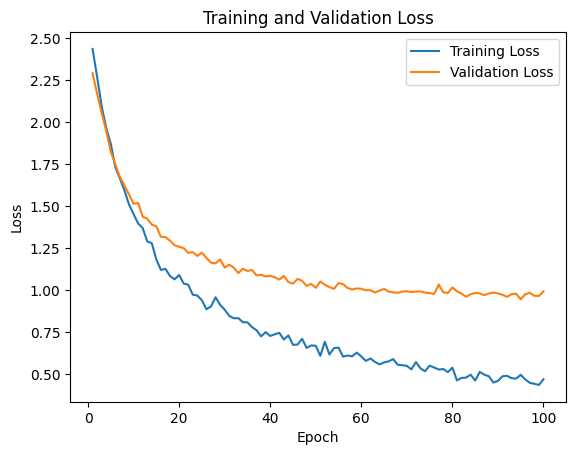

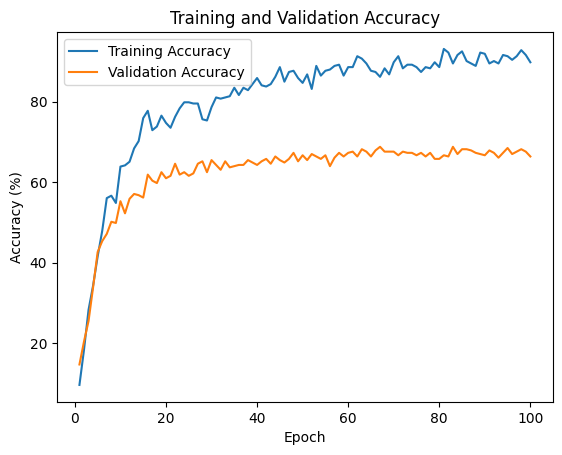

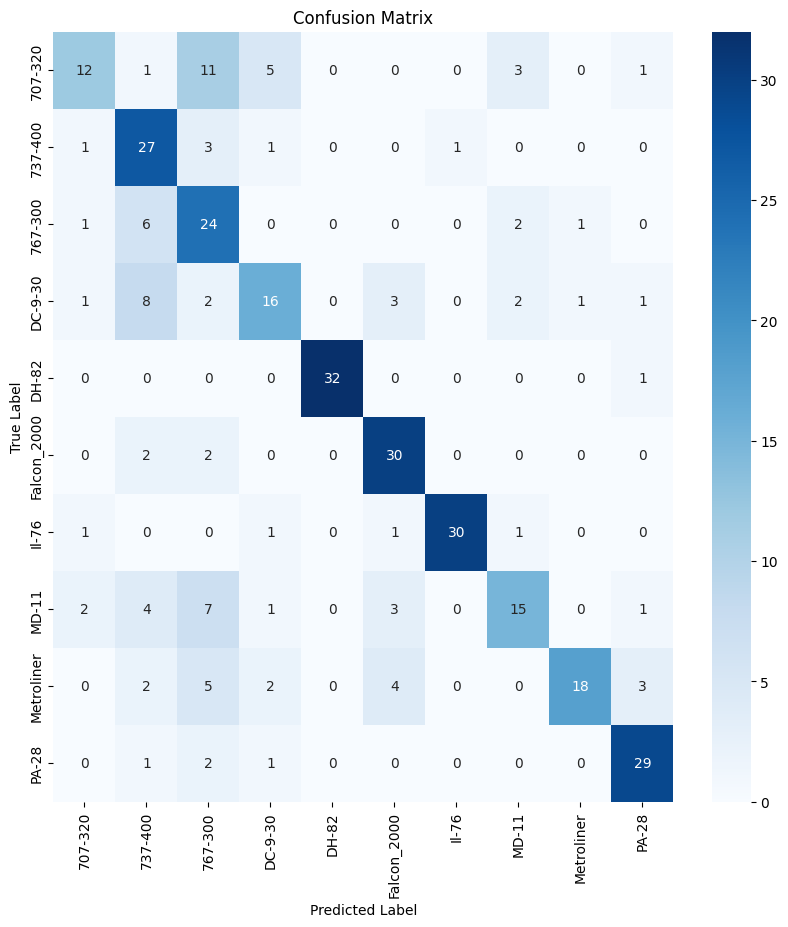

F1 Score:  0.6921623522180275


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models # Import models
from tqdm import tqdm # Import tqdm for progress bar
import seaborn as sns # Import seaborn for confusion matrix visualization
from sklearn.metrics import confusion_matrix, f1_score # Import confusion_matrix and f1_score
import matplotlib.pyplot as plt # Import matplotlib for plotting


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load pre-trained model & freeze the layers
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# -----------------------------------------------------------------------------


# Replace the last fully connected layer with a 10-classes layer -
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# -----------------------------------------------------------------------------

# Move the model to the GPU if available -
model = model.to(device)
# -----------------------------------------------------------------------------

# Define a loss function and optimizer -
criterion =  nn.CrossEntropyLoss()
optimizer =  optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# -----------------------------------------------------------------------------

# Lists for loss and accuracy to plot later
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Train the model - write the training loop
'''
in the loop you need to keep track of training and validation accuracy.
Print the training & validation loss & accuracy after every epoch.

Remember when you evaluate the model on val or test set, set the model to eval
mode, and trun off graients requirement. Once you're done, set the model back to
train mode
'''
# Assuming train_loader and val_loader are defined and available
trainloader = train_loader # Using existing train_loader
valloader = val_loader # Using existing val_loader
testloader = test_loader # Using existing test_loader

batch_losses = [] # List to store loss after each batch
epochs = 100

# Early stopping parameters
best_val_loss = float('inf') # Monitor validation loss for early stopping
patience = 10
epochs_no_improve = 0

print("Starting training with early stopping...")
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    model.train() # Set model to training mode
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} - Training"), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels =  data[0].to(device), data[1].to(device)

        # zero the parameter gradients

        optimizer.zero_grad()


        # forward + backward + optimize

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        # print & accumulate training statistics

        running_loss += loss.item()



    train_loss = running_loss / len(trainloader) # Calculate average loss for the epoch
    train_accuracy_epoch = 100 * correct / total # Calculate accuracy for the epoch
    train_losses.append(train_loss)
    train_accuracy.append(train_accuracy_epoch)

    # Validation at the end of the epoch
    model.eval() # Set mode to eval mode & tell torch no gradients are required.
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():

      # loop through the data and find accuracy and loss for all val data

        for data in tqdm(valloader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(valloader)
    val_accuracy_epoch = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracy.append(val_accuracy_epoch)


    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy_epoch:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy_epoch:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Optionally save the best model state
        # torch.save(model.state_dict(), 'best_cnn_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break # Stop training loop


print('Finished Training')
# -----------------------------------------------------------------------------

# ------------------------------- Plotting -------------------------------------
# Plot training loss over time
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss') # Plot against epoch number
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss') # Plot against epoch number
plt.title('Training and Validation Loss')
plt.xlabel('Epoch') # Corrected label
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy') # Plot against epoch number
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy') # Plot against epoch number
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch') # Corrected label
plt.ylabel('Accuracy (%)')
plt.legend()
# -----------------------------------------------------------------------------

# Test the model on test data and get confusion matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(testloader, desc="Evaluating on Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# -----------------------------------------------------------------------------


# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
# Use class_names for tick labels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# -----------------------------------------------------------------------------

# Print F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: ', f1)

In [17]:
from sklearn.metrics import classification_report
import torch

# Ensure the model is in evaluation mode
model.eval()

y_true = []
y_pred = []

# Explicitly move the model to the device before evaluation
model = model.to(device)

# Disable gradient calculation
with torch.no_grad():
    for images, labels in testloader: # Use testloader from CNN training cell
        images, labels = images.to(device), labels.to(device) # Move to device
        outputs = model(images) # Use the trained CNN model
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist()) # Move labels to CPU before converting to list
        y_pred.extend(predicted.cpu().tolist()) # Move predictions to CPU before converting to list

# Print report
print(classification_report(y_true, y_pred, target_names=class_names)) # Use class_names defined earlier

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

     707-320       0.00      0.00      0.00        33
     737-400       0.10      0.64      0.17        33
     767-300       0.00      0.00      0.00        34
     DC-9-30       0.10      0.26      0.15        34
       DH-82       0.00      0.00      0.00        33
 Falcon_2000       0.17      0.09      0.12        34
       Il-76       0.25      0.06      0.10        34
       MD-11       0.00      0.00      0.00        33
  Metroliner       0.00      0.00      0.00        34
       PA-28       0.00      0.00      0.00        33

    accuracy                           0.10       335
   macro avg       0.06      0.10      0.05       335
weighted avg       0.06      0.10      0.05       335



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##4. Hyperparameter Tuning:
Fine-tune a pre-trained ResNet18 model on the CIFAR-10 dataset to improve accuracy.

In [19]:
# Load pre-trained model
model = models.resnet18(pretrained=True)
print("Pre-trained ResNet18 model loaded.")

# Get the number of input features of the last fully connected layer
num_ftrs = model.fc.in_features

# Create a new fully connected layer with the correct number of output features
model.fc = nn.Linear(num_ftrs, len(class_names))

print(f"Replaced the last fully connected layer with a layer having {len(class_names)} output features.")
print(f"New last layer: {model.fc}")

# Inspect the model structure to decide which layers to unfreeze
# print(model) # Uncomment to see the full model structure

# Unfreeze all layers (full fine-tuning)
# This is a common strategy when the new dataset is significantly different
# from the dataset the model was pre-trained on.
print("Unfreezing all layers for full fine-tuning.")
for param in model.parameters():
    param.requires_grad = True

print("All layers are now unfrozen.")

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

# Define the optimizer that supports different learning rates
# Separate parameters into two groups: backbone and final layer
backbone_params = []
fc_params = []

for name, param in model.named_parameters():
    if param.requires_grad: # Only include trainable parameters
        if 'fc' in name: # Parameters of the final fully connected layer
            fc_params.append(param)
        else: # Parameters of the backbone layers
            backbone_params.append(param)

# Define different learning rates for the parameter groups
backbone_lr = 0.0001 # Smaller learning rate for the backbone
fc_lr = 0.001      # Potentially larger learning rate for the final layer

# Define the optimizer (e.g., Adam) with parameter groups
optimizer = optim.Adam([
    {'params': backbone_params, 'lr': backbone_lr},
    {'params': fc_params, 'lr': fc_lr}
])

# Define the loss function
criterion = nn.CrossEntropyLoss()

print("Optimizer defined with different learning rates for backbone and final layer.")
print(f"Backbone Learning Rate: {backbone_lr}")
print(f"Final Layer Learning Rate: {fc_lr}")



Pre-trained ResNet18 model loaded.
Replaced the last fully connected layer with a layer having 10 output features.
New last layer: Linear(in_features=512, out_features=10, bias=True)
Unfreezing all layers for full fine-tuning.
All layers are now unfrozen.
Number of trainable parameters: 11181642
Optimizer defined with different learning rates for backbone and final layer.
Backbone Learning Rate: 0.0001
Final Layer Learning Rate: 0.001


##5 Train the Final fine Tuned Model


In [32]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU if available
model = model.to(device)

# Lists for loss and accuracy to plot later
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Set the number of training epochs
epochs = 100 # Use a reasonable maximum number of epochs

# Early stopping parameters
best_val_loss = float('inf') # Monitor validation loss for early stopping
patience = 10
epochs_no_improve = 0

print("Starting training with early stopping...")
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    model.train() # Set model to training mode
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # accumulate training statistics
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader) # Calculate average loss for the epoch
    train_accuracy_epoch = 100 * correct / total # Calculate accuracy for the epoch
    train_losses.append(train_loss)
    train_accuracy.append(train_accuracy_epoch)

    # Validation at the end of the epoch
    model.eval() # Set mode to eval mode & tell torch no gradients are required.
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        # loop through the data and find accuracy and loss for all val data
        for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy_epoch = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracy.append(val_accuracy_epoch)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy_epoch:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy_epoch:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model state based on validation loss
        torch.save(model.state_dict(), 'best_fine_tuned_resnet18.pth')
        print("Saved best model state.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break # Stop training loop

print('Finished Training')

# Save the final model state dictionary at the very end of training
torch.save(model.state_dict(), 'final_fine_tuned_resnet18.pth')
print("\nFinal fine-tuned model state dictionary saved to 'final_fine_tuned_resnet18.pth'")

Using device: cuda
Starting training with early stopping...


Epoch 1/100 - Training:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Epoch 1: Train Loss: 0.0067, Train Accuracy: 99.70%, Val Loss: 0.5859, Val Accuracy: 81.98%
Saved best model state.


Epoch 2/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch 2: Train Loss: 0.0047, Train Accuracy: 100.00%, Val Loss: 0.5769, Val Accuracy: 82.58%
Saved best model state.


Epoch 3/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 3: Train Loss: 0.0032, Train Accuracy: 100.00%, Val Loss: 0.5891, Val Accuracy: 82.58%


Epoch 4/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Epoch 4: Train Loss: 0.0024, Train Accuracy: 100.00%, Val Loss: 0.5867, Val Accuracy: 82.88%


Epoch 5/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch 5: Train Loss: 0.0046, Train Accuracy: 100.00%, Val Loss: 0.5575, Val Accuracy: 84.38%
Saved best model state.


Epoch 6/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch 6: Train Loss: 0.0015, Train Accuracy: 100.00%, Val Loss: 0.5396, Val Accuracy: 84.68%
Saved best model state.


Epoch 7/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]


Epoch 7: Train Loss: 0.0028, Train Accuracy: 100.00%, Val Loss: 0.5379, Val Accuracy: 84.38%
Saved best model state.


Epoch 8/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 8: Train Loss: 0.0022, Train Accuracy: 100.00%, Val Loss: 0.5399, Val Accuracy: 85.29%


Epoch 9/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch 9: Train Loss: 0.0017, Train Accuracy: 100.00%, Val Loss: 0.5428, Val Accuracy: 85.59%


Epoch 10/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Epoch 10: Train Loss: 0.0095, Train Accuracy: 99.70%, Val Loss: 0.6301, Val Accuracy: 83.48%


Epoch 11/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 11: Train Loss: 0.0061, Train Accuracy: 100.00%, Val Loss: 0.6029, Val Accuracy: 81.98%


Epoch 12/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch 12: Train Loss: 0.0076, Train Accuracy: 99.70%, Val Loss: 0.6379, Val Accuracy: 82.28%


Epoch 13/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Epoch 13: Train Loss: 0.0047, Train Accuracy: 100.00%, Val Loss: 0.5969, Val Accuracy: 83.48%


Epoch 14/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]


Epoch 14: Train Loss: 0.0100, Train Accuracy: 99.70%, Val Loss: 0.8461, Val Accuracy: 79.58%


Epoch 15/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch 15: Train Loss: 0.0049, Train Accuracy: 100.00%, Val Loss: 0.7703, Val Accuracy: 81.08%


Epoch 16/100 - Validation: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


Epoch 16: Train Loss: 0.0068, Train Accuracy: 100.00%, Val Loss: 0.7350, Val Accuracy: 81.08%


Epoch 17/100 - Validation: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 17: Train Loss: 0.0040, Train Accuracy: 100.00%, Val Loss: 0.6634, Val Accuracy: 81.38%
Early stopping triggered after 17 epochs.
Finished Training

Final fine-tuned model state dictionary saved to 'final_fine_tuned_resnet18.pth'


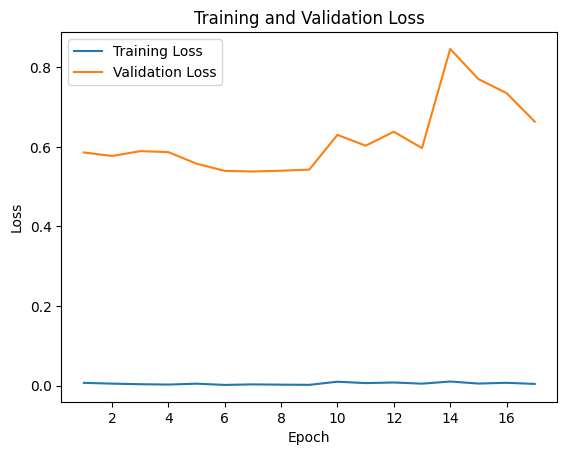

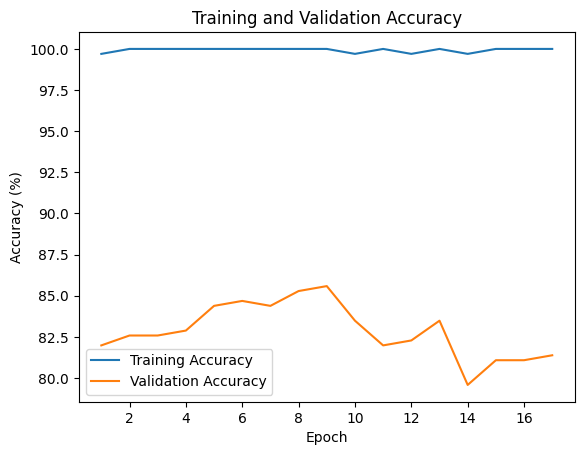

Evaluating on Test Set:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating on Test Set: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


F1 Score:  0.8737105680389263


In [33]:
# Plot training loss over time
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss') # Plot against epoch number
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss') # Plot against epoch number
plt.title('Training and Validation Loss')
plt.xlabel('Epoch') # Corrected label
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy over time
plt.figure()
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy') # Plot against epoch number
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy') # Plot against epoch number
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch') # Corrected label
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Test the model on test data and get confusion matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



# Print F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print('\nF1 Score: ', f1)

In [34]:
from sklearn.metrics import classification_report
import torch

# Ensure the model is in evaluation mode
model.eval()

y_true = []
y_pred = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in testloader: # Use testloader from CNN training cell
        images, labels = images.to(device), labels.to(device) # Move to device
        outputs = model(images) # Use the trained CNN model
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist()) # Move labels to CPU before converting to list
        y_pred.extend(predicted.cpu().tolist()) # Move predictions to CPU before converting to list

# Print report
print(classification_report(y_true, y_pred, target_names=class_names)) # Use class_names defined earlier

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

     707-320       0.68      0.76      0.71        33
     737-400       0.90      0.82      0.86        33
     767-300       0.75      0.71      0.73        34
     DC-9-30       0.97      0.88      0.92        34
       DH-82       0.94      0.97      0.96        33
 Falcon_2000       0.97      0.91      0.94        34
       Il-76       0.97      0.94      0.96        34
       MD-11       0.71      0.91      0.80        33
  Metroliner       0.97      0.88      0.92        34
       PA-28       0.94      0.94      0.94        33

    accuracy                           0.87       335
   macro avg       0.88      0.87      0.87       335
weighted avg       0.88      0.87      0.87       335



Creating confusion matrix...


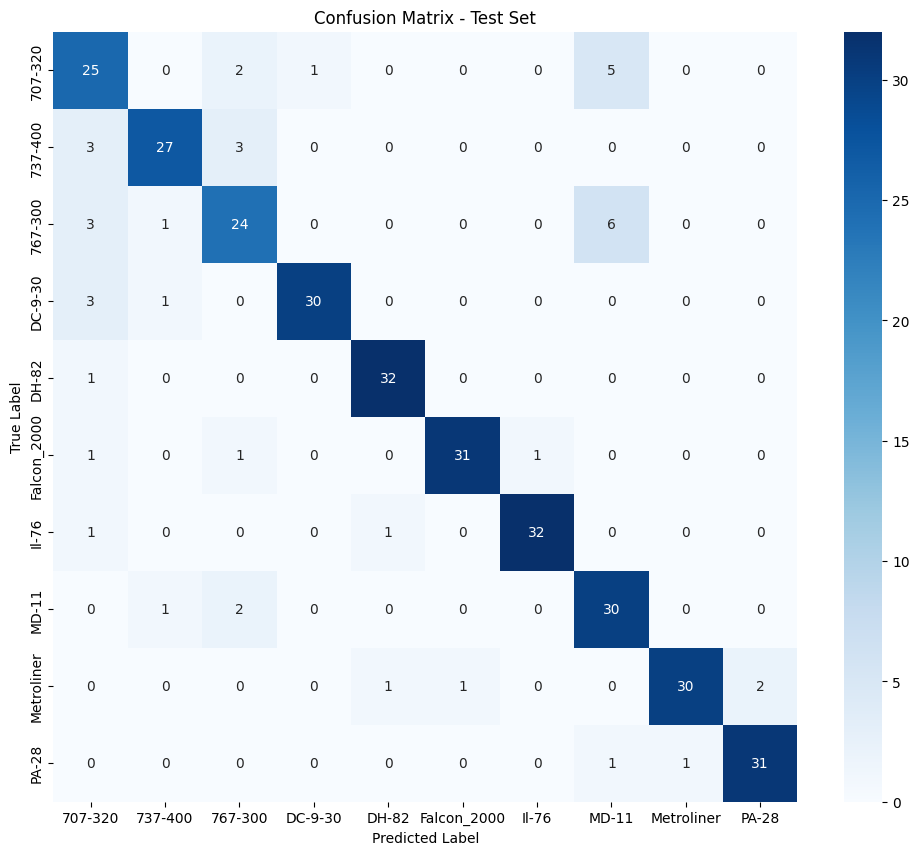


Confusion Matrix Analysis:

Per-class Accuracy:
 1. 707-320                  : 0.7576
 2. 737-400                  : 0.8182
 3. 767-300                  : 0.7059
 4. DC-9-30                  : 0.8824
 5. DH-82                    : 0.9697
 6. Falcon_2000              : 0.9118
 7. Il-76                    : 0.9412
 8. MD-11                    : 0.9091
 9. Metroliner               : 0.8824
10. PA-28                    : 0.9394

Most Confused Class Pairs:
  767-300 → MD-11: 6 misclassifications
  707-320 → MD-11: 5 misclassifications
  DC-9-30 → 707-320: 3 misclassifications
  767-300 → 707-320: 3 misclassifications
  737-400 → 767-300: 3 misclassifications


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot confusion matrix
print("Creating confusion matrix...")
# Use confusion_matrix from sklearn and plot with seaborn
cm = confusion_matrix(y_true, y_pred) # Use y_true and y_pred from the evaluation cell
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) # Use class_names
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight') # Uncomment to save the figure
plt.show()

# Analyze confusion matrix
# cm = confusion_matrix(test_true_labels, test_predictions) # cm is already calculated above
print("\nConfusion Matrix Analysis:")
print("=" * 40)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, (class_name, acc) in enumerate(zip(class_names, per_class_accuracy)):
    print(f"{i+1:2d}. {class_name:<25}: {acc:.4f}")

# Find most confused pairs
print("\nMost Confused Class Pairs:")
confusion_pairs = []
# Use len(class_names) instead of NUM_CLASSES
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((cm[i, j], class_names[i], class_names[j]))

confusion_pairs.sort(reverse=True)
for count, true_class, pred_class in confusion_pairs[:5]:
    print(f"  {true_class} → {pred_class}: {count} misclassifications")

Analyzing misclassified examples...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 10 misclassified examples


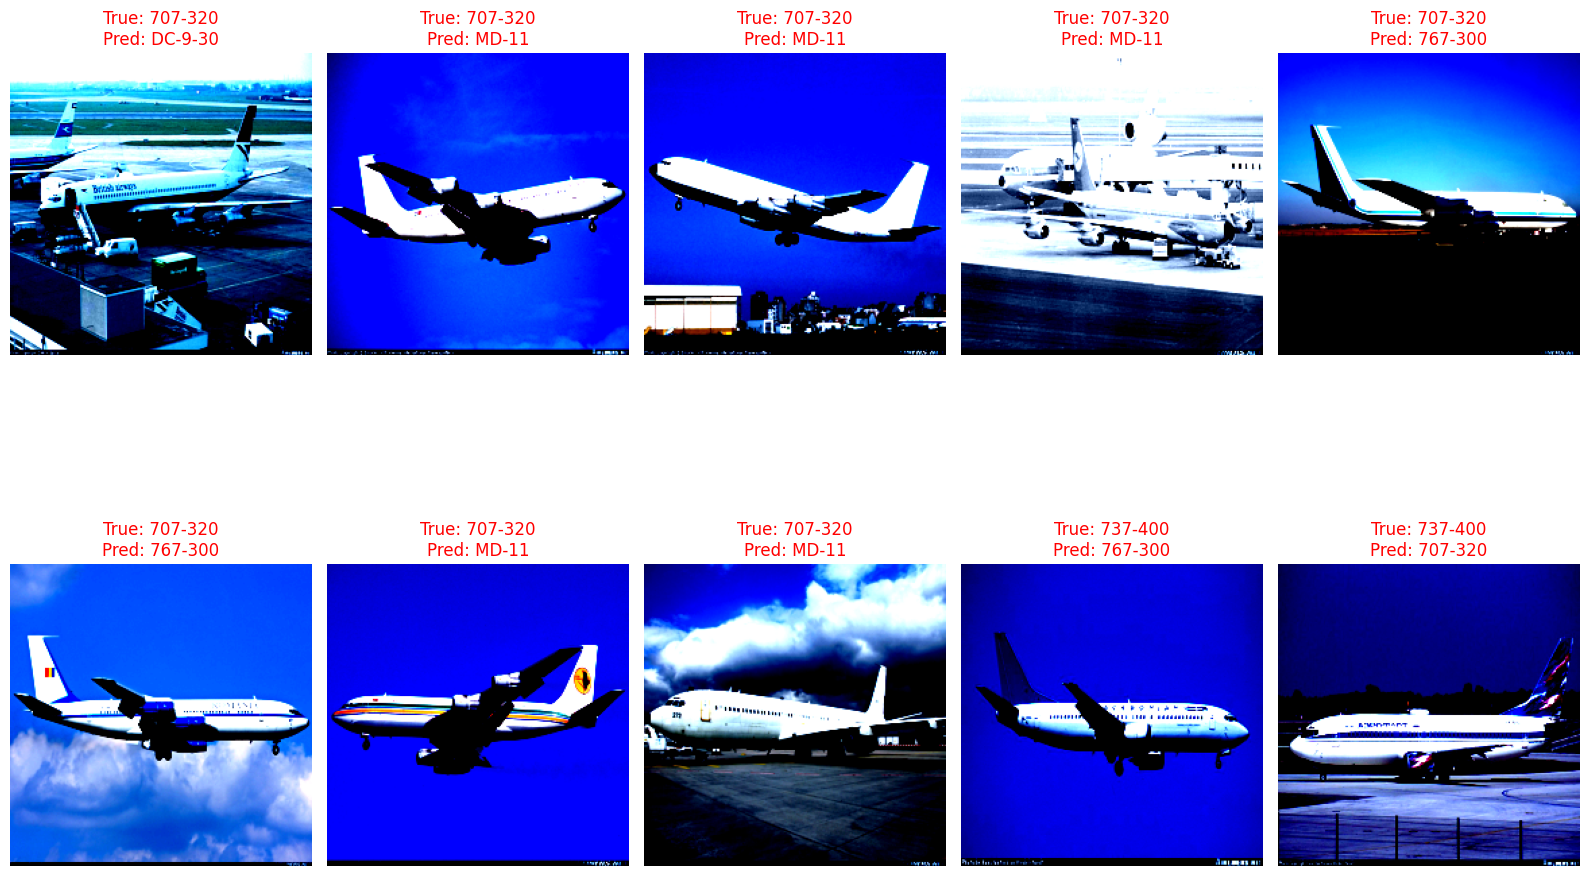


Misclassification Analysis:

Example 1:
  True class: 707-320
  Predicted class: DC-9-30
  Confidence: 0.6701
  Top 3 predictions:
    1. DC-9-30: 0.6701
    2. 707-320: 0.1995
    3. 767-300: 0.0701

Example 2:
  True class: 707-320
  Predicted class: MD-11
  Confidence: 0.7765
  Top 3 predictions:
    1. MD-11: 0.7765
    2. Il-76: 0.1426
    3. DC-9-30: 0.0357

Example 3:
  True class: 707-320
  Predicted class: MD-11
  Confidence: 0.8053
  Top 3 predictions:
    1. MD-11: 0.8053
    2. Il-76: 0.1012
    3. 707-320: 0.0547

Example 4:
  True class: 707-320
  Predicted class: MD-11
  Confidence: 0.8484
  Top 3 predictions:
    1. MD-11: 0.8484
    2. Metroliner: 0.0592
    3. PA-28: 0.0470

Example 5:
  True class: 707-320
  Predicted class: 767-300
  Confidence: 0.4966
  Top 3 predictions:
    1. 767-300: 0.4966
    2. 707-320: 0.4696
    3. 737-400: 0.0097


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the get_misclassified_examples function
def get_misclassified_examples(model, dataloader, class_names, device, num_examples=10):
    """
    Identifies misclassified examples from a dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): The dataloader to get examples from.
        class_names (list): A list of class names.
        device (torch.device): The device the model is on (cpu or cuda).
        num_examples (int): The maximum number of misclassified examples to return.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              information about a misclassified example.
    """
    model.eval()
    misclassified = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if predicted[i] != labels[i]:
                    misclassified.append({
                        'image': inputs[i].cpu(),
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item(),
                        'true_class': class_names[labels[i].item()],
                        'predicted_class': class_names[predicted[i].item()],
                        'confidence': probabilities[i, predicted[i].item()].item(),
                        'probabilities': probabilities[i].cpu().numpy()
                    })
                    if len(misclassified) >= num_examples:
                        return misclassified
    return misclassified

# Define the plot_misclassified_examples function
def plot_misclassified_examples(misclassified_examples, figsize=(16, 12)):
    """
    Plots misclassified examples with their true and predicted labels.

    Args:
        misclassified_examples (list): A list of dictionaries from get_misclassified_examples.
        figsize (tuple): Figure size for the plot.

    Returns:
        matplotlib.figure.Figure: The generated figure.
    """
    num_examples = len(misclassified_examples)
    if num_examples == 0:
        print("No misclassified examples to plot.")
        return None

    fig, axes = plt.subplots(min((num_examples + 4) // 5, 2), 5, figsize=figsize) # Adjust grid based on num_examples
    axes = axes.flatten()

    for i, example in enumerate(misclassified_examples):
        ax = axes[i]
        img = example['image']
        # Convert tensor to numpy array and transpose for matplotlib
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(f"True: {example['true_class']}\nPred: {example['predicted_class']}", color='red')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    return fig


# Get misclassified examples
print("Analyzing misclassified examples...")
misclassified_examples = get_misclassified_examples(
    model, test_loader, class_names, device=device, num_examples=10 # Changed DEVICE to device
)

print(f"Found {len(misclassified_examples)} misclassified examples")

if misclassified_examples:
    # Plot misclassified examples
    misc_fig = plot_misclassified_examples(misclassified_examples, figsize=(16, 12))
    # Ensure 'plots' directory exists if saving
    # os.makedirs('plots', exist_ok=True)
    # plt.savefig('plots/misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze misclassification patterns
    print("\nMisclassification Analysis:")
    print("=" * 40)

    for i, example in enumerate(misclassified_examples[:5]):
        print(f"\nExample {i+1}:")
        print(f"  True class: {example['true_class']}")
        print(f"  Predicted class: {example['predicted_class']}")
        print(f"  Confidence: {example['confidence']:.4f}")

        # Show top 3 predictions
        top_indices = np.argsort(example['probabilities'])[-3:][::-1]
        print(f"  Top 3 predictions:")
        for j, idx in enumerate(top_indices):
            print(f"    {j+1}. {class_names[idx]}: {example['probabilities'][idx]:.4f}")
else:
    print("No misclassified examples found in the test set!")

In [37]:
# Create comprehensive performance summary
print("=" * 60)
print("AIRCRAFT CLASSIFICATION MODEL - PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Total classes: {len(class_names)}")
print(f"   • Training samples: {len(train_dataset)}")
print(f"   • Validation samples: {len(val_dataset)}")
print(f"   • Test samples: {len(test_dataset)}")
print(f"   • Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

print(f"\n🏗️ MODEL ARCHITECTURE:")
print(f"   • Base model: Softmax Classifier")
print(f"   • Fine-tuned model: ResNet-18 (pre-trained)")
print(f"   • Transfer learning: Yes")
print(f"   • Trainable parameters: {trainable_params:,}")

print(f"\n⚙️  TRAINING CONFIGURATION:")
print(f"   • Batch size: {BATCH_SIZE}") #
print(f"   • Learning rate: Different for backbone and FC layer (as defined in optimizer)")
print(f"   • Backbone Learning Rate: {backbone_lr}")
print(f"   • Final Layer Learning Rate: {fc_lr}")
print(f"   • Epochs trained: {len(train_losses)}")
print(f"   • Early stopping patience: {patience}")
print(f"   • Optimizer: Adam (as defined in the fine-tuning step)") # Based on the fine-tuning code
print(f"   • Loss function: CrossEntropyLoss")

print(f"\n📈 TRAINING RESULTS:")
# Use the last values from the lists as training_history was not defined
print(f"   • Final training accuracy: {train_accuracy[-1]:.4f}%")
print(f"   • Final validation accuracy: {val_accuracy[-1]:.4f}%")
# Calculate best validation accuracy from the list
print(f"   • Best validation accuracy: {max(val_accuracy):.4f}%")
# Calculate training-validation gap if both are available
if train_accuracy and val_accuracy:
     print(f"   • Training-validation gap (final): {train_accuracy[-1] - val_accuracy[-1]:.4f}%")


print(f"\n🎯 TEST SET PERFORMANCE:")
# test_accuracy is available
print(f"   • Best Test accuracy: {np.mean(per_class_accuracy):.4f}%")

# Print F1 score as it was calculated
from sklearn.metrics import f1_score # Import f1_score
f1 = f1_score(y_true, y_pred, average='weighted') # Recalculate f1 score
print(f"   • Weighted F1 Score: {f1:.4f}")


print(f"\n🔍 CLASS-WISE PERFORMANCE:")
print("   • Refer to the classification report above for detailed per-class metrics.")




AIRCRAFT CLASSIFICATION MODEL - PERFORMANCE SUMMARY

📊 DATASET INFORMATION:
   • Total classes: 10
   • Training samples: 332
   • Validation samples: 333
   • Test samples: 335
   • Total samples: 1000

🏗️ MODEL ARCHITECTURE:
   • Base model: Softmax Classifier
   • Fine-tuned model: ResNet-18 (pre-trained)
   • Transfer learning: Yes
   • Trainable parameters: 11,181,642

⚙️  TRAINING CONFIGURATION:
   • Batch size: 32
   • Learning rate: Different for backbone and FC layer (as defined in optimizer)
   • Backbone Learning Rate: 0.0001
   • Final Layer Learning Rate: 0.001
   • Epochs trained: 17
   • Early stopping patience: 10
   • Optimizer: Adam (as defined in the fine-tuning step)
   • Loss function: CrossEntropyLoss

📈 TRAINING RESULTS:
   • Final training accuracy: 100.0000%
   • Final validation accuracy: 81.3814%
   • Best validation accuracy: 85.5856%
   • Training-validation gap (final): 18.6186%

🎯 TEST SET PERFORMANCE:
   • Best Test accuracy: 0.8717%
   • Weighted F1 Sco